In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f6d0b44c4c29e490466250bc65f61a53ac4d01688452f2e61ec6a3e98b85e58d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from xgboost.spark import SparkXGBClassifier
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler,StringIndexer
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("XGB Trainer")\
    .getOrCreate()
sc = spark.sparkContext

In [5]:
# Read the dataset as a spark dataframe
df = spark.read.csv('drive/My Drive/cleaned_v2.csv',header = True,inferSchema = True)

In [6]:
# Drop unnecessaey cols
df = df.drop('Offender_age','Offender_sex')

In [7]:
# Conver the categorical columns to index
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
idxed_cols = ['%s_idx'%i for i in str_cols]

In [8]:
indexer = StringIndexer(inputCols=str_cols, outputCols=idxed_cols)
indexed = indexer.fit(df).transform(df)

In [9]:
# Drop original categorical variables from the indexed dataset
indexed = indexed.drop(*str_cols)

In [10]:
indexed.show()

+----+----------+----------------+------------------+---------+---------------+---------+--------------+----------------+--------------+---------------+-----------------+----------+----------------+---------------+----------+-----------------+
|Year|Victim_age|add_victim_count|add_offender_count|State_idx|Agency_type_idx|Month_idx|Crime_type_idx|Crime_status_idx|Victim_sex_idx|Victim_race_idx|Offender_race_idx|Weapon_idx|Relationship_idx|Crime_cause_idx|County_idx|Offender_demo_idx|
+----+----------+----------------+------------------+---------+---------------+---------+--------------+----------------+--------------+---------------+-----------------+----------+----------------+---------------+----------+-----------------+
|2000|        25|               0|                 0|     38.0|            0.0|      4.0|           0.0|             0.0|           1.0|            1.0|              1.0|       0.0|             2.0|            0.0|      87.0|              0.0|
|2000|        24|       

In [11]:
# Define the input variables for the XGB algorithm
input_features = indexed.columns[:-1]
#input_features

In [12]:
vector_assembler = VectorAssembler(inputCols=input_features, outputCol='features')
data = vector_assembler.transform(indexed)
#data.show()

In [14]:
# Split the dataset in to train and test sets
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=69)

In [15]:
xgb_classifier = SparkXGBClassifier(
      features_col="features",
      label_col="Offender_demo_idx",
      eval_metric='merror',
      eta = 1,
      max_depth = 8,
      min_child_weight = 7,
      gamma = 10,
      subsample = 0.8,
      nrounds = 1500,
      num_workers=2)

In [16]:
# Train the model
xgb_model = xgb_classifier.fit(trainingData)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'gamma': 10, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8, 'eta': 1, 'nrounds': 1500, 'eval_metric': 'merror', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [17]:
# Generate the prediction and save into a dataframe
predict_df = xgb_model.transform(testData)
#predict_df.show()

In [18]:
# Evalaute the xgb classifier using MulticlassClassificationEvaluator()
evaluator = MulticlassClassificationEvaluator(labelCol="Offender_demo_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predict_df)
print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.785406


In [19]:
# Generate the Confusion Matrix
y_true = predict_df.select("Offender_demo_idx")
y_true = y_true.toPandas()

y_pred = predict_df.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[53718,   646,   778,   268,     0,     8],
       [ 6189,   902,    51,     2,     0,     0],
       [ 3951,    32,  2566,    16,     0,    61],
       [ 3037,     5,    34,  1069,     0,     6],
       [  367,    34,    87,     0,     0,     1],
       [  265,     0,   103,    10,     0,   125]])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

<Figure size 640x480 with 0 Axes>

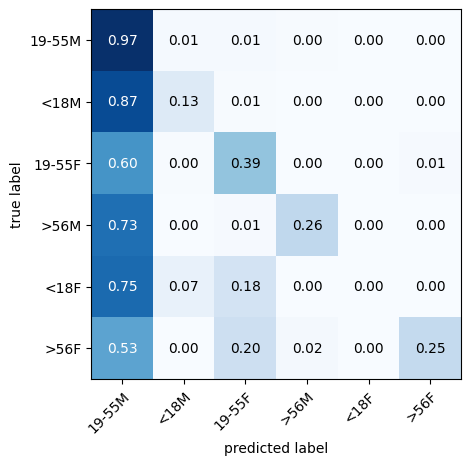

In [20]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

class_names = ['19-55M','<18M','19-55F','>56M','<18F','>56F']
plt.figure()
plot_confusion_matrix(cnf_matrix, class_names=class_names,
                      show_absolute=False,
                      show_normed=True)


Tuning - need more cluster power

In [ ]:
xgb_tune = SparkXGBClassifier(num_workers=3, label_col='Offender_demo_idx', missing=0.0)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

paramGrid = ParamGridBuilder()\
  .addGrid(xgb_tune.max_depth, [2, 5])\
  .addGrid(xgb_tune.n_estimators, [10, 100])\
  .build()

evaluator = MulticlassClassificationEvaluator(metricName='merror',
                              labelCol=xgb_tune.getLabelCol(),
                              predictionCol=xgb_tune.getPredictionCol())


In [ ]:
from pyspark.ml.feature import VectorIndexer
vectorAssembler = VectorAssembler(inputCols=input_features, outputCol='rawFeatures')

vectorIndexer = VectorIndexer(inputCol='rawFeatures', outputCol='tunefeatures')

In [ ]:
from pyspark.ml import Pipeline
cv = CrossValidator(estimator=xgb_tune, evaluator=evaluator, estimatorParamMaps=paramGrid)

pipeline = Pipeline(stages=[vectorAssembler, vectorIndexer, cv])
pipelineModel = pipeline.fit(trainingData)
predictions = pipelineModel.transform(testData)

In [ ]:
predictions = pipelineModel.transform(testData)
display(predictions.select('Offender_demo_idx','prediction',*input_features))

In [ ]:
evaluator_tune = MulticlassClassificationEvaluator(metricName='merror',
                              labelCol=xgb_tune.getLabelCol(),
                              predictionCol=xgb_tune.getPredictionCol())

merror = evaluator_tune.evaluate(predictions)
print('classification error on our test set: %g' % merror)